## train with finetune data
Goal here was to test whether simply increasing learning rate was enough to abolish drops in accuracy that depend on number of distractors, or whether (alternativley) abolishing the effect in part depends on increasing the training data.

In [2]:
import os
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import searchnets
from searchnets.utils.general import reorder_paths

In [3]:
results_dir = Path('../../../data/results/')
data_prep_dir = Path('../../../data/data_prepd_for_nets/')

In [4]:
stims = ('RVvGV', 'RVvRHGV', '2_v_5')

In [5]:
data_gz_finetune_paths = sorted(list(data_prep_dir.glob('alexnet*finetune*gz')))
data_gz_finetune_paths = [str(path) for path in data_gz_finetune_paths]
data_gz_finetune_paths = reorder_paths(data_gz_finetune_paths, stims)

In [6]:
train_types = ('finetune', 'train_finetune_data', 'train')

In [7]:
data_gz_paths = []
results_gz_paths = []

for train_type in train_types:
    if 'finetune' in train_type:
        data_gz_paths.extend(data_gz_finetune_paths)
    else:
        data_gz_train_paths = []
        for stim in stims:
            data_gz_train_paths.append(
                list(data_prep_dir.glob(f'alexnet*_train_{stim}_data.gz'))[0]
            )
        data_gz_train_paths = [str(path) for path in data_gz_train_paths]
        data_gz_train_paths = reorder_paths(data_gz_train_paths, stims)
        data_gz_paths.extend(data_gz_train_paths)

    results_gz_paths_this_train_type = []
    for stim in stims:
        results_gz_paths_this_train_type.append(
            list(results_dir.glob(f'alexnet_{train_type}_{stim}/*alexnet*gz'))[0]
        )
    results_gz_paths_this_train_type = [
        str(path) for path in results_gz_paths_this_train_type
    ]
    results_gz_paths_this_train_type = reorder_paths(
        results_gz_paths_this_train_type, stims)
    results_gz_paths.extend(results_gz_paths_this_train_type)

In [8]:
test_csv_path = '../../../data/csv/alexnet_finetune_train_finetune_data_train.csv'

In [34]:
searchnets.utils.general.results_csv(data_prep_dir,
                                     results_dir,
                                     test_csv_path=test_csv_path,
                                     nets=('alexnet',),
                                     train_types=train_types,
                                     stims=stims,
                                     target_condition=('present', 'absent', 'both'),
                                     data_gz_paths=data_gz_paths,
                                     results_gz_paths=results_gz_paths)

In [9]:
atft_df = pd.read_csv(test_csv_path)

In [10]:
atft_df.head()

,Unnamed: 0,net_name,train_type,net_number,stimulus,set_size,target_condition,accuracy,hit_rate,false_alarm_rate,d_prime
0,0,alexnet,finetune,0,RVvGV,1,present,1.00,NaN,NaN,NaN
1,1,alexnet,finetune,0,RVvGV,2,present,1.00,NaN,NaN,NaN
2,2,alexnet,finetune,0,RVvGV,4,present,1.00,NaN,NaN,NaN
3,3,alexnet,finetune,0,RVvGV,8,present,0.92,NaN,NaN,NaN
4,4,alexnet,finetune,0,RVvGV,1,absent,1.00,NaN,NaN,NaN


In [11]:
pal = sns.color_palette('muted')

In [12]:
def get_mean_both_condition(df, net_name, train_type, stimulus, metric):    
    df = df.loc[
    (df['net_name'] == net_name) & (df['train_type'] == train_type) &
    (df['stimulus'] == stimulus)]

    set_sizes = None
    net_nums = df['net_number'].unique()
    # get metric across set sizes for each training replicate
    # we end up with a list of vectors we can pass to ax.plot,
    # so that the 'line' for each training replicate gets plotted
    metric_both = []
    for net_num in net_nums:
        df_this_net_num = df.loc[(df['net_number'] == net_num)]
        # and each condition specified
        df_this_cond = df_this_net_num.loc[
            (df_this_net_num['target_condition'] == 'both')
        ]
        metric_vals = df_this_cond[metric].values
        metric_both.append(metric_vals)

        set_size = df_this_cond['set_size'].values
        if set_sizes is None:
            set_sizes = set_size
        else:
            assert np.array_equal(set_sizes, set_size), 'set sizes did not match'

    mn_metric_both = np.asarray(metric_both).mean(axis=0)
    return mn_metric_both, set_sizes

In [13]:
mn_2_v_5_finetune, set_sizes = get_mean_both_condition(atft_df, 
                                                    'alexnet',
                                                    'finetune',
                                                    '2_v_5',
                                                    'accuracy')
                        
mn_2_v_5_train_w_finetune, _ = get_mean_both_condition(atft_df, 
                                                    'alexnet',
                                                    'train_finetune_data',
                                                    '2_v_5',
                                                    'accuracy')
mn_2_v_5_train, _ = get_mean_both_condition(atft_df, 
                                                    'alexnet',
                                                    'train',
                                                    '2_v_5',
                                                    'accuracy')

tr_w_ft_diff = mn_2_v_5_train_w_finetune - mn_2_v_5_finetune

tr_diff = mn_2_v_5_train - mn_2_v_5_finetune

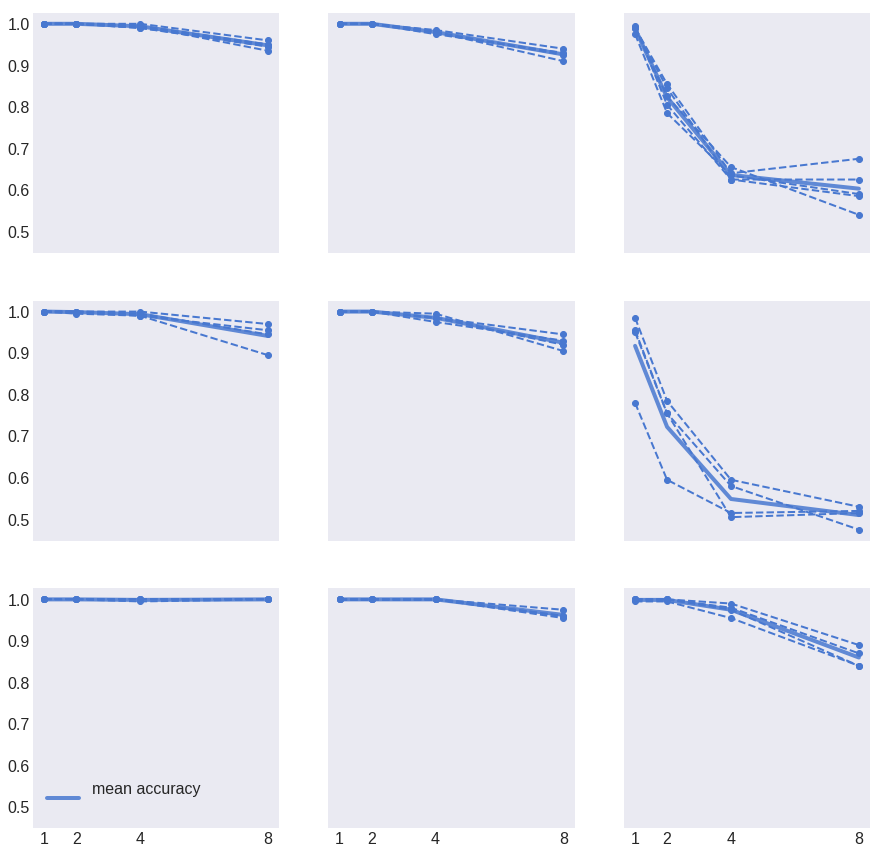

In [17]:
save_as = '../../static/fig3/alexnet-finetune-train-w-finetune-train-ipynb.png'

figsize=(15,15)
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=figsize)

net_name = 'alexnet'
for row, train_type in enumerate(train_types):
    for col, (stim_name, stim_abbrev) in enumerate(zip(
        ['feature', 'conjunction', 'spatial configuration'],
        ['RVvGV', 'RVvRHGV', '2_v_5'])):
            if row==2 and col==0:
                add_legend=True
            else:
                add_legend=False

            both_color = pal[0]
            mn_both_color = pal[0]

            searchnets.plot.metric_v_set_size_df(df=atft_df, net_name=net_name,
                                                 train_type=train_type, 
                                                 stimulus=stim_abbrev,
                                                 metric='accuracy', 
                                                 conditions=['both'],
                                                 both_color=both_color,
                                                 mn_both_color=mn_both_color,
                                                 set_ylim=False,
                                                 ax=ax[row, col],
                                                 ylim=(0.5, 1.05),
                                                 add_legend=add_legend,
                                                 save_as=save_as)

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

In [27]:
x

array([0, 1, 2, 3])

In [26]:
x - width / 2

array([-0.125,  0.875,  1.875,  2.875])

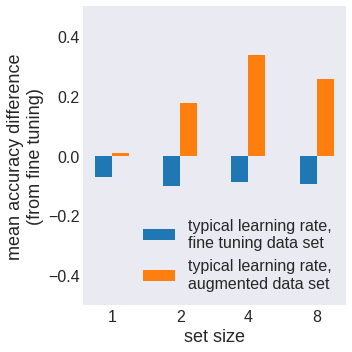

In [35]:
figsize=(5,5)
fig, ax = plt.subplots(figsize=figsize)

width = 0.25  # the width of the bars
x = np.arange(len(set_sizes))

ax.bar(x - width / 2, tr_w_ft_diff, width=width,
       label='typical learning rate,\nfine tuning data set')
ax.bar(x + width / 2, tr_diff, width=width,
       label='typical learning rate,\naugmented data set')
ax.set_xticks(x)
ax.set_xticklabels([str(set_size) for set_size in set_sizes])
ax.set_ylim([-0.5,0.5])
ax.legend(loc='lower right');
ax.set_xlabel('set size')
ax.set_ylabel('mean accuracy difference\n(from fine tuning)')
plt.tight_layout()
plt.savefig(
    '../../static/fig3/alexnet-finetune-train-w-finetune-train-diff-mean-ipynb.png'
)

Above result suggests that, no, simply increaseing the learning rate was not enough.